#### 90803 Data Cleaning and Question Definition
# Data Sourcing: Getting ACS 5 year data using the census API
### This script: Getting City Level Data (on the "places" geography level via the census API) 
This script does not read in any data from a file. Instead, it downloads ACS data via an API. It also downloads shape files with geometries of cities from the internet. This gets us around having to store these large files locally. 

**Team 14**

Colton Lapp & Chi-Shiun Tsai

In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from census import Census
from us import states
import numpy as np
import os
import seaborn as sns

In [2]:
#Initialize Census object using census API key
census_object = Census("bf6690c63fb4bbd43ccae839241e9be45bfc0881")

## Define variable lists to eventually call from census API

In [3]:
#ACS Variable Dictionary

#These variables will not need to be normalized by population
ACS_vars_other = { 'Name': 'NAME',
                  'Total Population': 'B01003_001E',
                  'Median Household Income': 'B19013_001E',
                  'Median Home Value': 'B25077_001E',
                  'Median Gross Rent':'B25064_001E',
                  'Renter Household': 'B25056_001E'}


#These vars will eventually be divided/normalized by "total population"
ACS_vars_to_normalize = {'Total Housing Units':'B25001_001E',
            'Race: White Alone':'B02001_002E',
            'Hispanic or Latino':'B03002_012E',
            'Population Age 25 or Older: Bachelor`s Degree':'B15003_022E',
            'Population Age 25 or Older: Doctorate Degree':'B15003_025E',
            'Pop 5-17 Speak only English at Home':'B16004_003E',
            'Population Age 15 or Older Never Married' : 'B12001_003E',
            'Population Age 15 or Older Never Married 2' : 'B12001_012E',
            'Population Age 65 or more' : 'B09020_001E',
            'Pop 65 or more Living in Nonfamily Households' : 'B09020_012E',
            'Females 20-64 w Own Children 0-17': 'B23003_010E',
            'Workers Age 16 or more': 'B08007_001E',
            'Workers 16 or more who Took Public Transportation to work': 'B08301_010E',
            'Workers 16 or more who Worked at Home' : 'B08301_021E',
            'Workers 16 or more who Drove Alone to Work' : 'B08301_003E',
            'Employed in Professional/Scientific/Technical Services' : 'C24030_018E',
            'Employed in Professional/Scientific/Technical Services 2' :  'C24030_045E',
            'Employed in Accommodation/Food Services' : 'C24030_026E',
            'Employed in Accommodation/Food Services 2' :  'C24030_053E',
            'Employed in Health Care/Social Assistance' : 'C24030_023E',
            'Employed in Health Care/Social Assistance 2' :  'C24030_050E',
            'Employed in Arts/Entertainment/Recreation' : 'C24030_025E',
            'Employed in Arts/Entertainment/Recreation 2' :  'C24030_052E',
            'Male 16+: Private For-Profit Self-Emp Inc Bus': 'B24080_005E', 
            'Male 16+: Private Not-For-Profit Worker': 'B24080_006E',
            'Civilian Population 18+: Veteran' : 'B21001_002E',
            'Population 35-64: Medicaid Coverage Only' : 'B27010_039E',
            'Population 35-64: No Health Insurance Coverage' : 'B27010_050E',
            'Households with No Internet Acces' : 'B28011_008E',
            'Households Receiving Food Stamps/SNAP': 'B22010_002E',
            'Households Below the Poverty Leve': 'B17017_002E',
            'Gross Rent 50% + of Household Income' : 'B25070_010E',
            'Owner Households by Year Moved In: 2017 or Later': 'B25038_003E',
            'Total Vacant Housing Units' : 'B25004_001E',
            'Housing Units Built in 2014 or Later' : 'B25034_002E'
            }

                                  

## Pull data from Census API
#### For 2020, pull all variables of interest. For 2019, pull only population so we can compute population change

In [4]:
#API Pull for "place" data from ACS 5 year dataset

#Create list of vars to pull using above dictionaries
fields_predictors = [i for i in ACS_vars_other.values() ] +[i for i in ACS_vars_to_normalize.values() ] 

#Pull all variables for 2020
places_data_2020 = census_object.acs5.state_place(fields = tuple(fields_predictors),year=2020, state_fips = '*', place='*')

#Pull only Population for 2019
places_data_2019 = census_object.acs5.state_place(fields = ('NAME', 'B01003_001E'),year=2019, state_fips = '*', place='*')


### Process Raw Data Pulls 
Turn into data frames, rename variables, convert to numeric, normalize variables, etc

In [5]:
#Convert data pulls into dataframes
cities_2020 = pd.DataFrame(places_data_2020).sort_values(by='B01003_001E', ascending=False)
cities_2019 = pd.DataFrame(places_data_2019).sort_values(by='B01003_001E', ascending=False)

#Rename population variables for 2020 data pull
cities_2020 = cities_2020.rename( dict( zip(  ACS_vars_other.values(),ACS_vars_other.keys()) ), axis=1)
cities_2020 = cities_2020.rename( dict( zip(  ACS_vars_to_normalize.values(),ACS_vars_to_normalize.keys()) ), axis=1)
cities_2020 = cities_2020.rename( {'Total Population':'Population 2020'}, axis=1)

#Rename population variable for 2019 pull
cities_2019 = cities_2019.rename({'B01003_001E': 'Population 2019'}, axis=1)


#Convert population vals to numeric
cities_2020['Population 2020'] = cities_2020['Population 2020'].apply(lambda x: int(x))
cities_2019['Population 2019'] = cities_2019['Population 2019'].apply(lambda x: int(x))

#Create GEOID combining states and places codes
cities_2020['GEOID'] = cities_2020['state'] + cities_2020['place'] 
cities_2019['GEOID'] = cities_2019['state'] + cities_2019['place'] 

#Merge 2019 and 2020 data by city FIPS code
cities_2020 = cities_2020.merge(cities_2019[['Population 2019', 'GEOID']], on ='GEOID' )

#Create %Pct Change in Population between 2019 and 2020
cities_2020['Pop Chng %'] = 100* (cities_2020['Population 2020']-cities_2020['Population 2019'])/cities_2020['Population 2019']

#Normalize Variables
for var in ACS_vars_to_normalize.keys():
    cities_2020[var] = 100* cities_2020[var]/cities_2020['Population 2020']


#Drop "Census designated Places" i.e. CDP because they are not really "towns" or "Cities"
cities_2020= cities_2020[ cities_2020["Name"].str.contains( 'CDP' )==False ]

#Drop where population is zero
cities_2020= cities_2020[ cities_2020["Population 2020"] > 0 ]

print("Shape of dataset:", cities_2020.shape)
cities_2020.head()

Shape of dataset: (19729, 46)


,Name,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,...,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,state,place,GEOID,Population 2019,Pop Chng %
0,"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,...,6.556830,6.763679,0.208245,3.913145,0.719466,36,51000,3651000,8419316,-0.472295
1,"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,...,5.838303,6.734288,0.256715,2.800433,0.887101,06,44000,0644000,3966936,0.159871
2,"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,...,6.614933,5.035996,0.455777,5.058372,0.868655,17,14000,1714000,2709534,-0.375969
3,"Houston city, Texas",2313238,53600.0,186800.0,1086.0,499608.0,42.481318,51.539271,44.471948,13.576078,...,6.563527,5.208932,0.410939,4.663031,2.628869,48,35000,4835000,2310432,0.121449
4,"Phoenix city, Arizona",1658422,60914.0,250800.0,1100.0,258077.0,37.805637,68.233176,42.647046,11.954557,...,4.791905,3.291020,0.706636,2.782283,1.114433,04,55000,0455000,1633017,1.555709


### Checking the correctness of our data: Looking at Target Variable (pop change %) vs Population

Text(0.5, 1.0, 'Population Change from 2019 to 2020 vs Population size 2020')

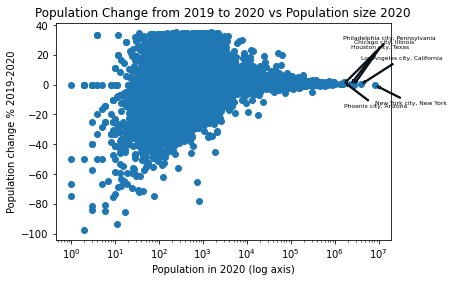

In [6]:
#Scatterplot of target variable against pop
temp = cities_2020[cities_2020['Pop Chng %'] <35 ].reset_index()

fig, ax = plt.subplots()
plt.xscale("log")
plt.scatter(temp['Population 2020'], temp['Pop Chng %'])

for i, txt in enumerate(temp['Name']):
    if i<6:
        ax.annotate( text= temp['Name'][i], 
                    xy = (temp['Population 2020'][i], temp['Pop Chng %'][i]),
                    xytext = (temp['Population 2020'][i], np.random.uniform(-40,35)+temp['Pop Chng %'][i]),
                                        fontsize=6, arrowprops=dict(arrowstyle="simple", connectionstyle="arc3"))
        
    elif temp['Pop Chng %'][i] >20 or temp['Pop Chng %'][i]<-15:
        if np.random.uniform(0,1) <.05:
            foo = 1 ;
            #ax.annotate(temp['Name'][i], (temp['Population 2020'][i], temp['Pop Chng %'][i]), fontsize=6)
                   
plt.xlabel("Population in 2020 (log axis)")
plt.ylabel("Population change % 2019-2020")
plt.title("Population Change from 2019 to 2020 vs Population size 2020")

# Read in Shape Files
#### Need to get geographies of cities to merge in with data. Will download these from Census website

Shape files are saved for every state so we will loop through each shape file and append them to each other to make one big one for the whole country

In [7]:
#Supress warnings
import warnings
warnings.filterwarnings('ignore')

#Read in places shp file for 2019
for state_fip in range(1,75):
    print("Downloading Shape File for state: ", state_fip)
    try:
        if state_fip <10:
            url = "https://www2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_0" + str(state_fip) + "_place.zip"
        else:
            url = "https://www2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_" + str(state_fip) + "_place.zip"

        if state_fip==1:      
            Alabama_shp = gpd.read_file(url)
        else:
            new_shp = gpd.read_file(url)
            Alabama_shp = Alabama_shp.append(new_shp, ignore_index=True)
    except:
        print("No Shape File found for state: ", state_fip)
        
#Show warnings
warnings.filterwarnings('default')

No Shape File found for state:  3
No Shape File found for state:  7
No Shape File found for state:  14
No Shape File found for state:  43
No Shape File found for state:  52
No Shape File found for state:  57
No Shape File found for state:  58
No Shape File found for state:  59
No Shape File found for state:  61
No Shape File found for state:  62
No Shape File found for state:  63
No Shape File found for state:  64
No Shape File found for state:  65
No Shape File found for state:  67
No Shape File found for state:  68
No Shape File found for state:  70
No Shape File found for state:  71
No Shape File found for state:  73
No Shape File found for state:  74


### Merge shape file and places dataframe on GEOID

In [8]:
#Rename alabama_shp (which has all shape files merged) to places_shp
places_shp = Alabama_shp

#Save merged shapefile into our directory
try:
    #Make directory
    working_dir = os.getcwd().split('/')
    working_dir = '/'.join(working_dir[0:-1])
    if not os.path.exists(working_dir +'/data/shape_files/CensusPlaces'):
        os.mkdir(working_dir +'/data/shape_files/CensusPlaces')
        
    #Save shape file
    places_shp.to_file(working_dir +'/data/shape_files/CensusPlaces/CensusPlaces.shp')  
except:
    print("Could not save shape file to directory")

#Merge shape files and data
places_merged =  cities_2020.merge(places_shp, on = "GEOID")
#Convert to geodataframe
places_merged = gpd.GeoDataFrame(places_merged)

#Print
places_merged.head(2)



,Name,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,...,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,...,C1,Y,N,G4110,A,777982727,434642000,+40.6634682,-073.9386968,"MULTIPOLYGON (((-74.04075 40.70017, -74.04073 ..."
1,"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,...,C1,Y,N,G4110,A,1214591312,87468461,+34.0193936,-118.4108248,"POLYGON ((-118.66818 34.18987, -118.66815 34.1..."


# Download States Shapefile for country outline
#### To make our maps look better, we should also map the state outlines for reference. Download this file from the census

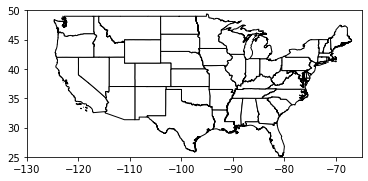

In [9]:

#Download USA 48 states shapefile
usa_shp = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip')
usa_shp['STATEFP'] = usa_shp['STATEFP'].apply(lambda x: int(x) )

#Plot State outline
base = usa_shp.plot(color='white', edgecolor='black')
plt.xlim([-130, -65])
plt.ylim([25,50])


#Save shape file to local directory
try:
    if not os.path.exists(working_dir +'/data/shape_files/USStates'):
        os.mkdir(working_dir +'/data/shape_files/CensusPlaces')
    #Save shape file
    usa_shp.to_file(working_dir +'/data/shape_files/USStates/US_States.shp')
except:
    print("Error: Could not save shape file to directory")

# Update population data Coordinate Reference System (CRS)


In [10]:
places_merged = places_merged.to_crs(usa_shp.crs)

# ACS Dataset Summary Stats

In [11]:
places_merged.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,...,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,Population 2019,Pop Chng %,ALAND,AWATER
count,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,...,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0,19729.0
mean,10538.0,-19340597.3,-21058078.0,-85862704.4,1717.1,51.3,82.5,10.1,9.9,0.5,...,5.6,6.1,2.1,0.6,11.0,1.0,10468.8,inf,16801744.9,1635101.7
std,83437.7,112059578.7,117066501.8,223321346.0,19267.1,49.4,20.7,18.2,7.0,1.1,...,4.8,4.9,2.3,1.4,47.2,2.5,83459.2,nan,107653269.6,43631763.2
min,1.0,-666666666.0,-666666666.0,-666666666.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-97.6,39033.0,0.0
25%,394.0,39514.0,77000.0,568.0,33.0,40.4,76.6,0.7,5.1,0.0,...,2.2,2.9,0.5,0.0,2.8,0.0,380.0,-3.7,1603293.0,0.0
50%,1229.0,50598.0,110900.0,721.0,131.0,46.1,90.5,3.5,8.3,0.1,...,4.6,5.1,1.6,0.3,5.5,0.2,1207.0,0.2,3897640.0,7057.0
75%,4767.0,64879.0,174800.0,916.0,605.0,53.1,96.4,9.9,12.9,0.6,...,7.8,8.0,3.1,0.8,10.0,1.2,4745.0,5.5,11620180.0,133509.0
max,8379552.0,250001.0,2000001.0,3501.0,2143429.0,3902.3,100.0,100.0,100.0,35.5,...,100.0,100.0,82.4,40.1,3834.9,150.0,8419316.0,inf,7433305220.0,5037858058.0


# Plot Population Change % on Map

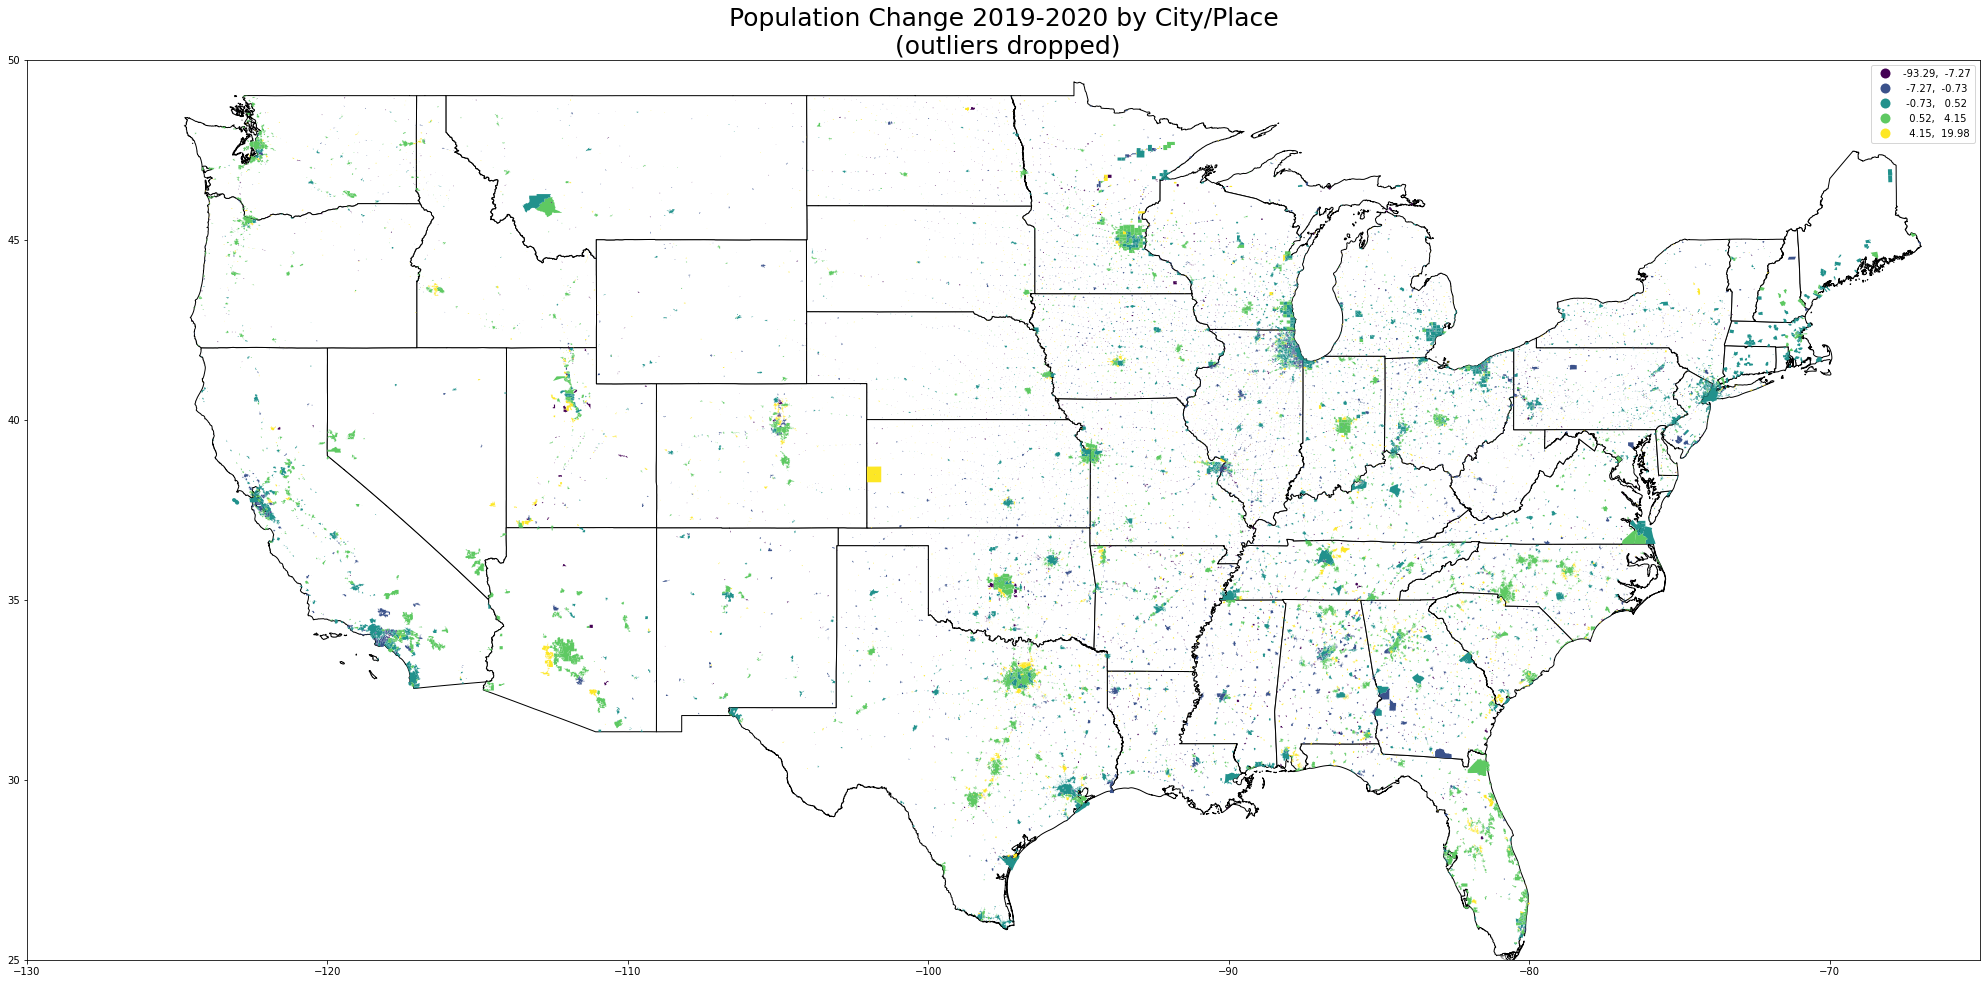

In [12]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (35,35))
ax.set_aspect('equal')

#Plot USA
usa_shp.plot(ax=ax,color='white', edgecolor='black')

# Plot data
states48 = places_merged[ places_merged['state'] != '15']
states48 = states48[ states48['state'] != '02']

states48 = states48.to_crs(usa_shp.crs)
states48=states48[states48['Pop Chng %']<20]

states48.plot(column = "Pop Chng %",
                       ax = ax, kind='geo', legend=True,
                      scheme='quantiles')
                        #kind='geo',
                       #cmap = "RdPu",
                      # legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Population Change 2019-2020 by City/Place\n (outliers dropped)', fontdict = {'fontsize': '25', 'fontweight' : '3'})


plt.xlim([-130,-65])
plt.ylim([25,50])
plt.show()

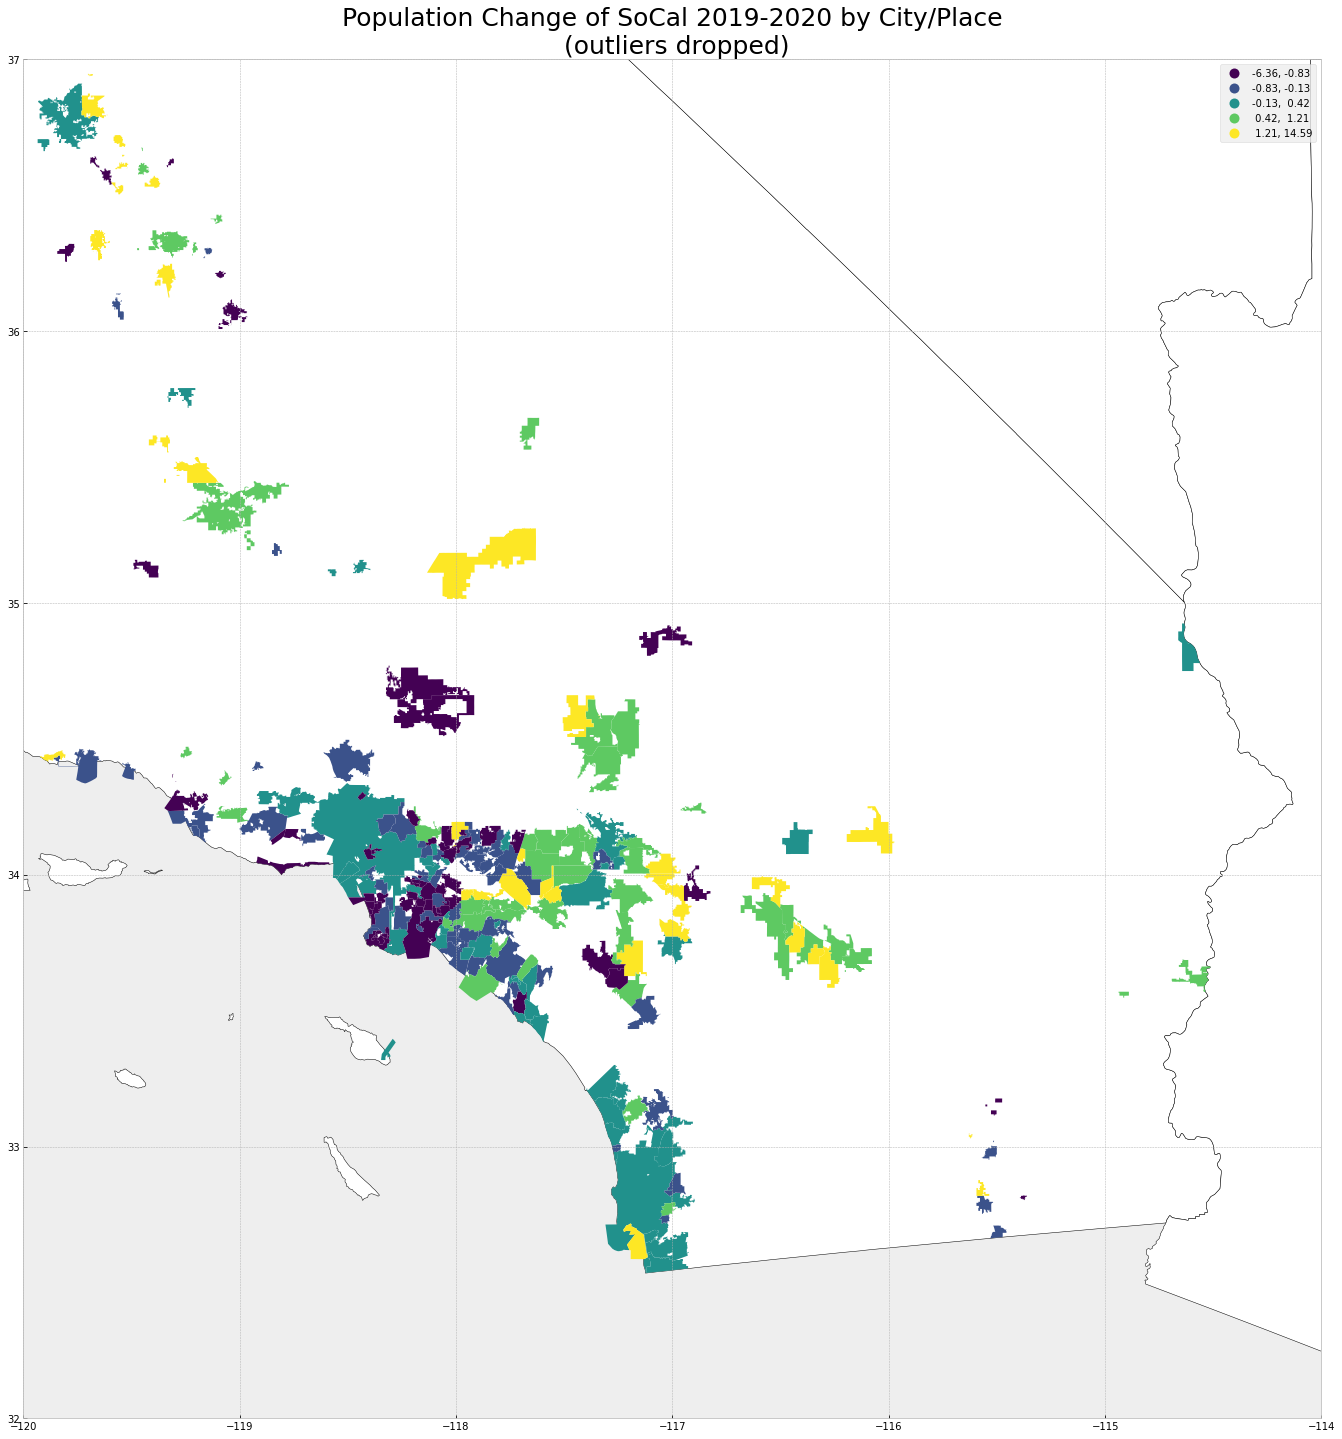

In [13]:
#Plot SoCal Only

fig, ax = plt.subplots(1, 1, figsize = (25,25))
ax.set_aspect('equal')

#Plot USA
usa_shp.plot(ax=ax,color='white', edgecolor='black')

#Create CA dataset
CA = states48[ states48['state'] == '06']
CA = CA[ CA['Pop Chng %'] >-8]
CA.plot(column = "Pop Chng %",
                       ax = ax, kind='geo', legend=True, scheme='quantiles')
# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Population Change of SoCal 2019-2020 by City/Place\n (outliers dropped)', fontdict = {'fontsize': '25', 'fontweight' : '3'})

plt.xlim([-120,-114])
plt.ylim([32,37])
plt.show()

# Save DataFrame

In [14]:
print("Final size of df:", places_merged.shape)

working_dir = os.getcwd().split('/')
working_dir = '/'.join(working_dir[0:-1])

try:
#Save as shp file (used for ARC GIS, other packages)
    if not os.path.exists(working_dir +'/data/data_cleaned/ACS5yrData/ACS_5yr_data.shp'): 
        os.mkdir( working_dir +'/data/data_cleaned/ACS5yrData/')
        places_merged.to_file(working_dir +'/data/data_cleaned/ACS5yrData/ACS_5yr_data.shp')  

    #Save as a pickle file so we preserve column names
    places_merged.to_pickle(working_dir +'/data/data_cleaned/ACS_5yr_data.pkl')

    #Drop geometries and save only the data (takes up less space, can save as dataframe)
    only_data = pd.DataFrame( places_merged.drop( ['geometry'], axis=1) )
    only_data.to_csv(working_dir +'/data/data_cleaned/ACS_5yr_data.csv', index=False )
except:
    print("Error: Could not save dataframe to local directory")

Final size of df: (19729, 62)


## References

1. https://pygis.io/docs/d_access_census.html
2. plotly how to chloropleth https://plotly.com/python/choropleth-maps/
3. layering maps in base plot geopandas https://geopandas.org/en/stable/docs/user_guide/mapping.html
4. downloading TIGER files https://www2.census.gov/geo/tiger/TIGER2019/PLACE/
5. geographic coverage areas https://www.census.gov/programs-surveys/acs/geography-acs/areas-published.html
6. places wikipedia https://en.wikipedia.org/wiki/Place_(United_States_Census_Bureau)
7. cbsa wikipedia pages https://en.wikipedia.org/wiki/Core-based_statistical_area
8. projections https://gis.stackexchange.com/questions/104005/choosing-projected-coordinate-system-for-mapping-all-us-states
